In [2]:
%matplotlib widget
import numpy as np
from astropy import units as u, constants as c
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import matplotlib
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.optimize import fsolve, fmin
from astropy.io import fits
import scipy.interpolate as interp
import emcee
import corner
from multiprocessing import Pool
import multiprocessing as mp
mp.cpu_count()

8

In [3]:
cnfw = 3.3 # NFW concentration parameter
z = 2.3 # redshift
Rs = 27 # kpc = Rvir = 90 kpc
H = cosmo.H(z).to('km/s/kpc').value
A = 1.2e7 #* u.km**2/u.s**2

bres = 2 # kpc
min_b = 10 # kpc
max_b = 250 # kpc
bvec = np.arange(min_b, max_b, bres)
vrawsamp = np.arange(-1000, 1000, 30)

bvec_final = np.arange(min_b, max_b+2.5, 5)
vvec_final = np.arange(-1000, 1050, 100)

In [4]:
lya_real = fits.open('lya_conv_240618.fits')[0].data

In [5]:
def model(theta):
    # vi, voff, a0out, a0in, gout, gin = theta
    vi, a0out, gout = theta

    # for the moment, no inflows
    voff = -144
    a0in = 0 #0.83
    gin = 0.1
    
    def vins(r):
        vin = voff + H*r
        return vin

    def vouts(r):
        vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
        return vout

    
    rmax_out = fmin(vouts, 35, ftol=0.5, disp=False)[0]
    # print(rmax_out)

    rmax_in = fsolve(vins, 100)[0] #xtol = 1
    # print(rmax_in)

    def ains(r):
        ain = (a0in * (r/100)**(-gin))
        return ain

    def aouts(r):
        if r > rmax_out:
            aout=0
        else:
            aout = (a0out * (r/100)**(-gout))
        return aout


    taulist_out = []
    taulist_in = []


    for bi, b in enumerate(bvec):
     
        lmax_out = np.sqrt(rmax_out**2 - b**2)
        lmax_in = np.sqrt(rmax_in**2 - b**2)
    
        larr_slowl_out = np.linspace(-lmax_out, -50, 50)
        nfast_out = int(150 * np.exp(-b/100)) #1500
        larr_fast_out = np.linspace(-50, 50, nfast_out)
        larr_slowr_out = np.linspace(50, lmax_out, 50)
        larr_out = np.concatenate([larr_slowl_out, larr_fast_out, larr_slowr_out])
    
        tau_outs = [aouts(np.sqrt(b**2 + li**2)) for li in larr_out]


        larr_slowl_in = np.linspace(-lmax_in, -50, 10)
        nfast_in = int(100 * np.exp(-b/100)) #1500
        larr_fast_in = np.linspace(-50, 50, nfast_in)
        larr_slowr_in = np.linspace(50, lmax_in, 10)
        larr_in = np.concatenate([larr_slowl_in, larr_fast_in, larr_slowr_in])
        tau_ins = [ains(np.sqrt(b**2 + li**2)) for li in larr_in]
        # print(tau_ins)

    
        r_out = np.sqrt(larr_out**2 + b**2)
        r_in = np.sqrt(larr_in**2 + b**2)
        # vout, vin = vels(r*u.kpc)

        vLOS_out = larr_out/r_out*vouts(r_out)
        vLOS_in = larr_in/r_in*vins(r_in)
        # plt.figure()
        # sc = plt.scatter(larr_out, vLOS_out, c=tau_outs)
        # sc1 = plt.scatter(larr_in, vLOS_in, c=tau_ins, cmap='inferno')
        # plt.xlabel('$\\ell$ (kpc)')
        # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
        # plt.colorbar(sc, label = '$\\tau_\\mathrm{out}$')
        # plt.colorbar(sc1, label = '$\\tau_\\mathrm{in}$')
        # plt.title(f'$b={b}$ kpc')
        # plt.axhline(0, c = 'k', alpha = 0.7, lw = 0.7, ls = '--')
        # plt.axvline(0, c = 'k', alpha = 0.7, lw = 0.7, ls = '--')
        # plt.tight_layout()
        # plt.show()
    
        
        
        l_minvout = larr_out[np.argmin(vLOS_out)]
        l_maxvout = larr_out[np.argmax(vLOS_out)]
        maxvout = np.nanmax(vLOS_out)
        if ~np.isfinite(maxvout):
            # print(f'bad {b}')
            for j in vrawsamp:
                taulist_out.append([b, j, 0])
        else:
            # outflow
            for i in range(int(np.floor(-maxvout)), int(np.ceil(maxvout)), 30): # 10 km/s
            
                possible_values = larr_out[(vLOS_out > i) & (vLOS_out < i+30)]
                l_near = possible_values[(possible_values > l_minvout) & (possible_values < l_maxvout)]
                l_far = possible_values[(possible_values < l_minvout) | (possible_values > l_maxvout)]
        
                tau_near_inds = [np.argwhere(larr_out == ln)[0][0] for ln in l_near]
                tau_out_near = np.array(tau_outs)[tau_near_inds]
        
                
                tau_far_inds = [np.argwhere(larr_out == ln)[0][0] for ln in l_far]
                tau_out_far = np.array(tau_outs)[tau_far_inds]
                tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far) 
    
                if np.isfinite(tau_tot):
                    taulist_out.append([b, i+15, tau_tot])
    
        #inflow
    
        l_minvin = larr_in[np.argmin(vLOS_in)]
        l_maxvin = larr_in[np.argmax(vLOS_in)]
        maxvin = np.nanmax(vLOS_in)
        # print(l_minvin, l_maxvin, maxvin)
        
        for i in range(int(np.floor(-maxvin)), int(np.ceil(maxvin)), 30):
        
            possible_values = larr_in[(vLOS_in > i) & (vLOS_in < i+30)]
            # print(possible_values)
            l_near = possible_values[(possible_values < l_minvin) & (possible_values > l_maxvin)]
            l_far = possible_values[(possible_values > l_minvin) | (possible_values < l_maxvin)]
    
            tau_near_inds = [np.argwhere(larr_in == ln)[0][0] for ln in l_near]
            tau_in_near = np.array(tau_ins)[tau_near_inds]
    
            
            tau_far_inds = [np.argwhere(larr_in == ln)[0][0] for ln in l_far]
            tau_in_far = np.array(tau_ins)[tau_far_inds]
            tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far) 
            # print(tau_tot)

            if np.isfinite(tau_tot):
                taulist_in.append([b, i+15, tau_tot])

    
    tauarr_out = np.array(taulist_out)
    tauarr_in = np.array(taulist_in)

    
    rawhmap = np.zeros((len(vrawsamp), len(bvec)))

    for bi, b in enumerate(bvec):
        bcut_out = (tauarr_out[:,0] == b)
        bcut_in = (tauarr_in[:,0] == b)
        if len(tauarr_out[bcut_out]) == 0:
            tout = vrawsamp*0.0
        else:
            tout = np.interp(vrawsamp, tauarr_out[:,1][bcut_out], tauarr_out[:,2][bcut_out], left=0, right=0)

        if len(tauarr_in[bcut_in]) == 0:
            tin = vrawsamp*0.0
        else:
            tin = np.interp(vrawsamp, tauarr_in[:,1][bcut_in], tauarr_in[:,2][bcut_in], left=0, right=0)

        rawhmap[:,bi] = tout + tin

    hmap_conv = convolve(rawhmap, Gaussian2DKernel(2,1), boundary = 'extend') # 100 km/s and 5 kpc sampling

    f = interp.RectBivariateSpline(vrawsamp, bvec, hmap_conv, kx=3, ky=3)
    hmap_reshaped = f(vvec_final, bvec_final)
    
    
    # plt.figure()
    # plt.imshow(hmap_reshaped, aspect='auto', origin='lower', extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()])
    # plt.show()
    
    # # print(hmap.shape)
    # plt.figure()
    # us = plt.imshow(rawhmap, origin='lower', extent = (bvec[0], bvec[-1], vrawsamp[0], vrawsamp[-1]), 
    #            aspect='auto', cmap='plasma')
    # plt.colorbar(us, label = '$\\tau_\\mathrm{tot}$')
    # plt.xlabel('b (kpc)')
    # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    # plt.title('Unsmoothed')
    # # plt.xscale('log')
    # plt.show()
    
    # plt.figure()
    # sm = plt.imshow(convolve(rawhmap, Gaussian2DKernel(2,4), boundary = 'extend'), origin='lower', extent = (bvec[0], bvec[-1], vrawsamp[0], vrawsamp[-1]), 
    #            aspect='auto', cmap='inferno')
    # plt.colorbar(sm, label = '$\\tau_\\mathrm{tot}$')
    # plt.xlabel('b (kpc)')
    # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    # plt.title('Smoothed')
    # # plt.xscale('log')
    # plt.show()

    return hmap_reshaped
    


In [6]:
def lnlike(theta, truth = lya_real):
    return -0.5 * np.nansum((lya_real - model(theta))**2)

In [7]:
def lnprior(theta):
    vi, a0out, gout = theta
    
    vir = (450 < vi < 650)
    # voffr = (-350 < voff < -20)
    a0outr = (0 < a0out < 1)
    goutr = (0 < gout < 3)

    if vir and a0outr and goutr:
        return 0.0

    return -np.inf
    
    

In [8]:
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [11]:


nwalkers = 100
niter = 200
initial = np.array([603, 0.3, 0.17])
ndims = len(initial)

p0 = initial_pos = [initial * (1 + 0.01*np.random.randn(ndims)) for i in range(nwalkers)]
p0

[array([6.06447346e+02, 3.02244134e-01, 1.70609139e-01]),
 array([6.00375958e+02, 3.03764501e-01, 1.70113074e-01]),
 array([6.08880477e+02, 2.94526701e-01, 1.70639475e-01]),
 array([6.03493904e+02, 2.97945580e-01, 1.70659909e-01]),
 array([5.97518022e+02, 3.01870427e-01, 1.69022903e-01]),
 array([5.96647455e+02, 3.01088203e-01, 1.69032212e-01]),
 array([5.95969713e+02, 2.96656089e-01, 1.71682972e-01]),
 array([5.91131780e+02, 2.95522929e-01, 1.68925092e-01]),
 array([6.05661934e+02, 2.97872677e-01, 1.68545166e-01]),
 array([6.03444431e+02, 3.02036140e-01, 1.69530353e-01]),
 array([6.01140319e+02, 3.03248792e-01, 1.70741325e-01]),
 array([6.03750195e+02, 3.00760417e-01, 1.69235764e-01]),
 array([5.97073653e+02, 3.06569316e-01, 1.70857631e-01]),
 array([5.99549259e+02, 3.06273094e-01, 1.73649516e-01]),
 array([5.95625984e+02, 2.99165359e-01, 1.69867343e-01]),
 array([5.98888796e+02, 2.97852491e-01, 1.70940883e-01]),
 array([6.22949361e+02, 2.99126513e-01, 1.70555066e-01]),
 array([6.1706

In [12]:
with Pool(6) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndims, lnprob, pool=pool)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    # return sampler, pos, prob, state

/tmp/ipykernel_2872153/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2872153/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2872153/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2872153/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2872153/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2872153/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)

Running production...


  1%|▍                                          | 2/200 [00:18<31:08,  9.44s/it]/tmp/ipykernel_2872153/3364415001.py:43: RuntimeWarning: invalid value encountered in sqrt
  lmax_out = np.sqrt(rmax_out**2 - b**2)
/tmp/ipykernel_2872153/3364415001.py:87: RuntimeWarning: All-NaN slice encountered
  maxvout = np.nanmax(vLOS_out)
  2%|▋                                          | 3/200 [00:28<30:40,  9.34s/it]/tmp/ipykernel_2872153/3364415001.py:43: RuntimeWarning: invalid value encountered in sqrt
  lmax_out = np.sqrt(rmax_out**2 - b**2)
/tmp/ipykernel_2872153/3364415001.py:87: RuntimeWarning: All-NaN slice encountered
  maxvout = np.nanmax(vLOS_out)
/tmp/ipykernel_2872153/3364415001.py:43: RuntimeWarning: invalid value encountered in sqrt
  lmax_out = np.sqrt(rmax_out**2 - b**2)
/tmp/ipykernel_2872153/3364415001.py:87: RuntimeWarning: All-NaN slice encountered
  maxvout = np.nanmax(vLOS_out)
  2%|▊                                          | 4/200 [00:37<30:46,  9.42s/it]/tmp/ipykernel_2872

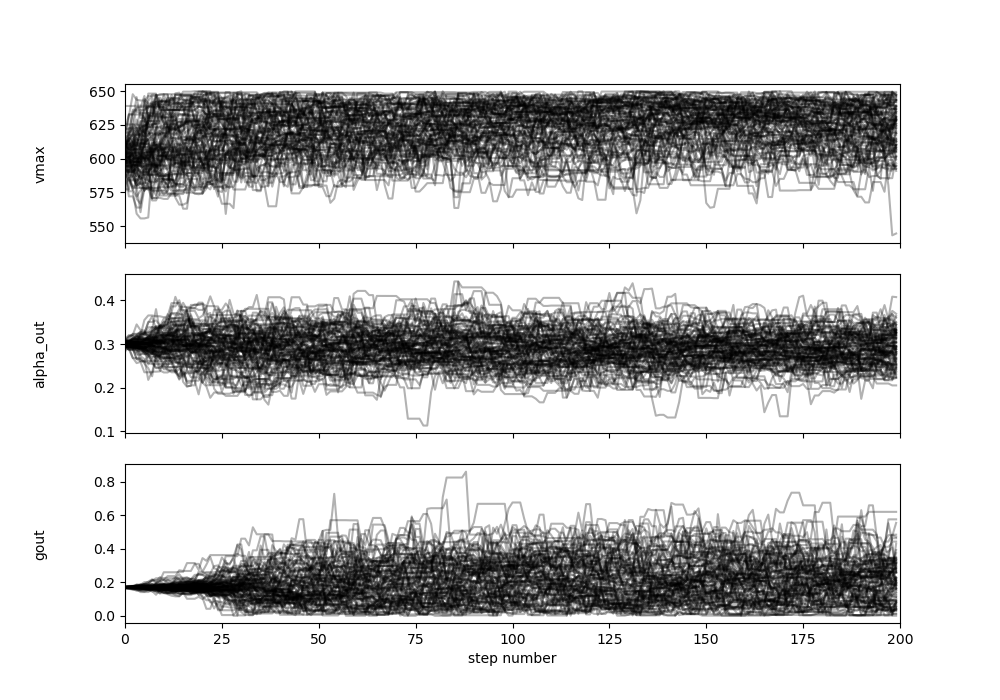

In [13]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["vmax", "alpha_out", "gout"]
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [14]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [15.91696518 13.94768698 14.33103743]

In [15]:
flat_samples = sampler.get_chain(discard=25, flat=True) # discard=100, thin=15, flat=True
print(flat_samples.shape)

(17500, 3)


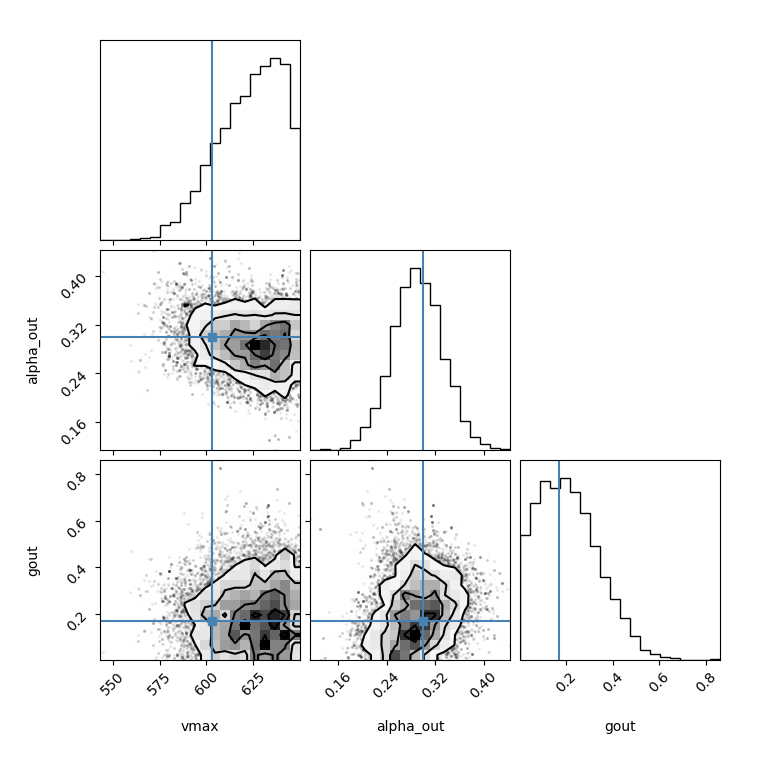

In [16]:
fig = corner.corner(
    flat_samples, labels=labels, truths=initial
);

In [24]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndims,lnprob)

Running production...


/tmp/ipykernel_2869270/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2869270/3364415001.py:106: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far)
/tmp/ipykernel_2869270/3364415001.py:131: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far)
  2%|▋                                        | 8/500 [04:39<4:47:04, 35.01s/it]/tmp/ipykernel_2869270/3364415001.py:43: RuntimeWarning: invalid value encountered in sqrt
  lmax_out = np.sqrt(rmax_out**2 - b**2)
/tmp/ipykernel_2869270/3364415001.py:87: RuntimeWarning: All-NaN slice encountered
  maxvout = np.nanmax(vLOS_out)
Traceback (most recent call last):
  File "/scr/nprusins/python/py312/lib/python3.12/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

emcee: Exception while calling your likelihood function:
  params: [5.96948263e+02 2.98278406e-01 1.70709978e-01]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [12]:
thtest = (603, 0.3, 0.17)
lnlike(thtest)

/tmp/ipykernel_2869270/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2869270/3364415001.py:106: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far)
/tmp/ipykernel_2869270/3364415001.py:131: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far)


-7.174882546368743

/tmp/ipykernel_2869270/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2869270/3364415001.py:106: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far)
/tmp/ipykernel_2869270/3364415001.py:131: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far)


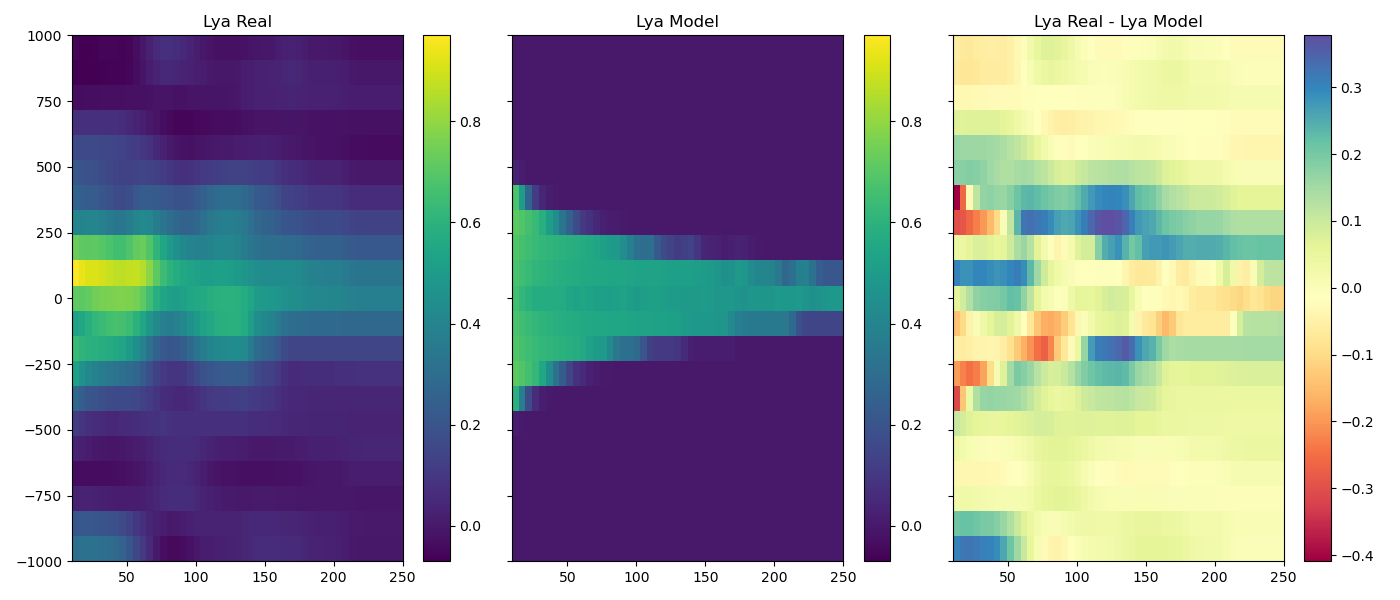

In [11]:
thtest = (603, 0.3, 0.17) #vout, vin, aout, ain, gout, gin
lya_model = model(thtest) 

vmi, vma = -0.07, 0.97

fig, ax = plt.subplots(1,3, figsize = (14,6), sharex=True, sharey=True)
re = ax[0].imshow(lya_real, aspect='auto', origin='lower', 
                  extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(re, ax=ax[0])
ax[0].set_title('Lya Real')

mod = ax[1].imshow(lya_model, aspect='auto', origin='lower', 
                   extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(mod, ax=ax[1])
ax[1].set_title('Lya Model')

diff = ax[2].imshow(lya_real - lya_model, aspect='auto', origin='lower',
                    extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], cmap='Spectral')
fig.colorbar(diff, ax=ax[2])
ax[2].set_title('Lya Real - Lya Model')
fig.tight_layout()
plt.show()